In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
import time

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../../ESC-50/audio/'

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset,
                        kind='mfcc',
                        blocksize=blocksize,
                        overlap=overlap,
                        folds=5,
                        feature_bag=False
                       )

In [11]:
df.describe()

,target,h_target,fold
count,2000.000000,2000.00000,2000.000000
mean,24.500000,0.64000,3.000000
std,14.434479,0.48012,1.414567
min,0.000000,0.00000,1.000000
25%,12.000000,0.00000,2.000000
50%,24.500000,1.00000,3.000000
75%,37.000000,1.00000,4.000000
max,49.000000,1.00000,5.000000


In [12]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,52.009557,4.327045,5.696827,6.522973,3.426770,9.314700,8.897445,1.613144,3.654356,6.125930,...,-0.430331,0.430331,29.442891,33.986595,7.463287,129.495423,54.772801,0,0,2
1,88.404377,82.645071,55.548627,51.936489,32.090942,23.103625,23.082517,18.536499,16.418501,15.469806,...,0.475820,-0.102448,15.695233,20.199985,3.943083,20.152053,1.728330,0,0,2
2,86.987377,78.083572,51.433488,51.561430,33.107803,31.318922,21.869279,15.681414,22.181496,16.827397,...,0.254841,0.158864,14.345672,19.755847,3.758124,17.172734,1.683485,0,0,2
3,80.670230,68.750011,19.582458,23.847321,18.158782,20.392203,9.204180,11.268402,12.634953,12.072391,...,0.278538,0.105655,25.330133,34.365584,4.991139,27.321271,10.232799,0,0,2
4,81.355627,60.950895,35.026463,48.047609,53.739915,42.014673,48.515288,36.766431,53.463175,52.233060,...,0.425719,0.243835,12.205491,13.338520,5.419358,15.416913,3.034387,0,14,5


In [13]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,111.831480,54.815637,46.530396,47.713482,63.097985,40.124086,41.283977,39.126589,47.458985,44.103655,...,0.002231,-0.186397,8.548450,18.617724,4.990710,17.572631,2.932278,1,19,1
1,84.256878,45.595653,58.295530,40.866884,45.134938,42.510526,39.975935,35.020607,43.299812,33.619786,...,0.258236,-0.033466,8.731446,27.077679,6.396933,17.748301,6.235493,1,19,1
2,80.760855,50.189665,60.488470,45.657319,50.449612,37.361851,38.274903,37.943290,40.972668,33.157679,...,-0.005670,-0.237720,8.569524,15.897844,6.637912,13.312597,4.520961,1,19,1
3,96.653713,64.606767,43.944312,43.241847,47.136254,49.828710,44.103221,32.363491,37.862344,40.250450,...,0.314561,-0.078892,7.394061,16.869421,5.333168,14.245536,2.655378,1,19,1
4,95.009044,47.391309,52.084750,31.367530,41.518049,48.650198,45.167534,37.675397,36.512091,38.452338,...,0.014457,0.051697,6.610542,16.245310,8.406345,11.734778,3.869954,1,19,1


In [14]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
train_yy = train['target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']
test_yy = test['target']

# Deep Net
Separate into classes

In [15]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def deep_net():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(50,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [16]:
%%time

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=80, score_func=chi2)),
    ('feat_red', PCA(n_components=50)),
    ('classify', KerasClassifier(build_fn=deep_net, 
                       epochs=50, 
                       batch_size=35, 
                       validation_split=0.05)
    )
])

clf.fit(train_X, train_yy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               6528      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

26436/26436 [==============================] - 2s 85us/step - loss: 2.0475 - acc: 0.4041 - val_loss: 2.9353 - val_acc: 0.2421
Epoch 49/50
26436/26436 [==============================] - 2s 88us/step - loss: 2.0469 - acc: 0.4040 - val_loss: 2.9472 - val_acc: 0.2428
Epoch 50/50
26436/26436 [==============================] - 2s 87us/step - loss: 2.0468 - acc: 0.4018 - val_loss: 2.8593 - val_acc: 0.2507
CPU times: user 4min 35s, sys: 1min 59s, total: 6min 35s
Wall time: 2min 1s


0.3182477516681172
Confusion matrix, without normalization
[[ 25   0   0 ...   0   0   3]
 [  8  48   0 ...   0   0   1]
 [  1   0  15 ...   0   2   4]
 ...
 [  0   0   0 ...  43   0   0]
 [  4   0   1 ...   0  51   0]
 [  0   0   1 ...   0   0 105]]


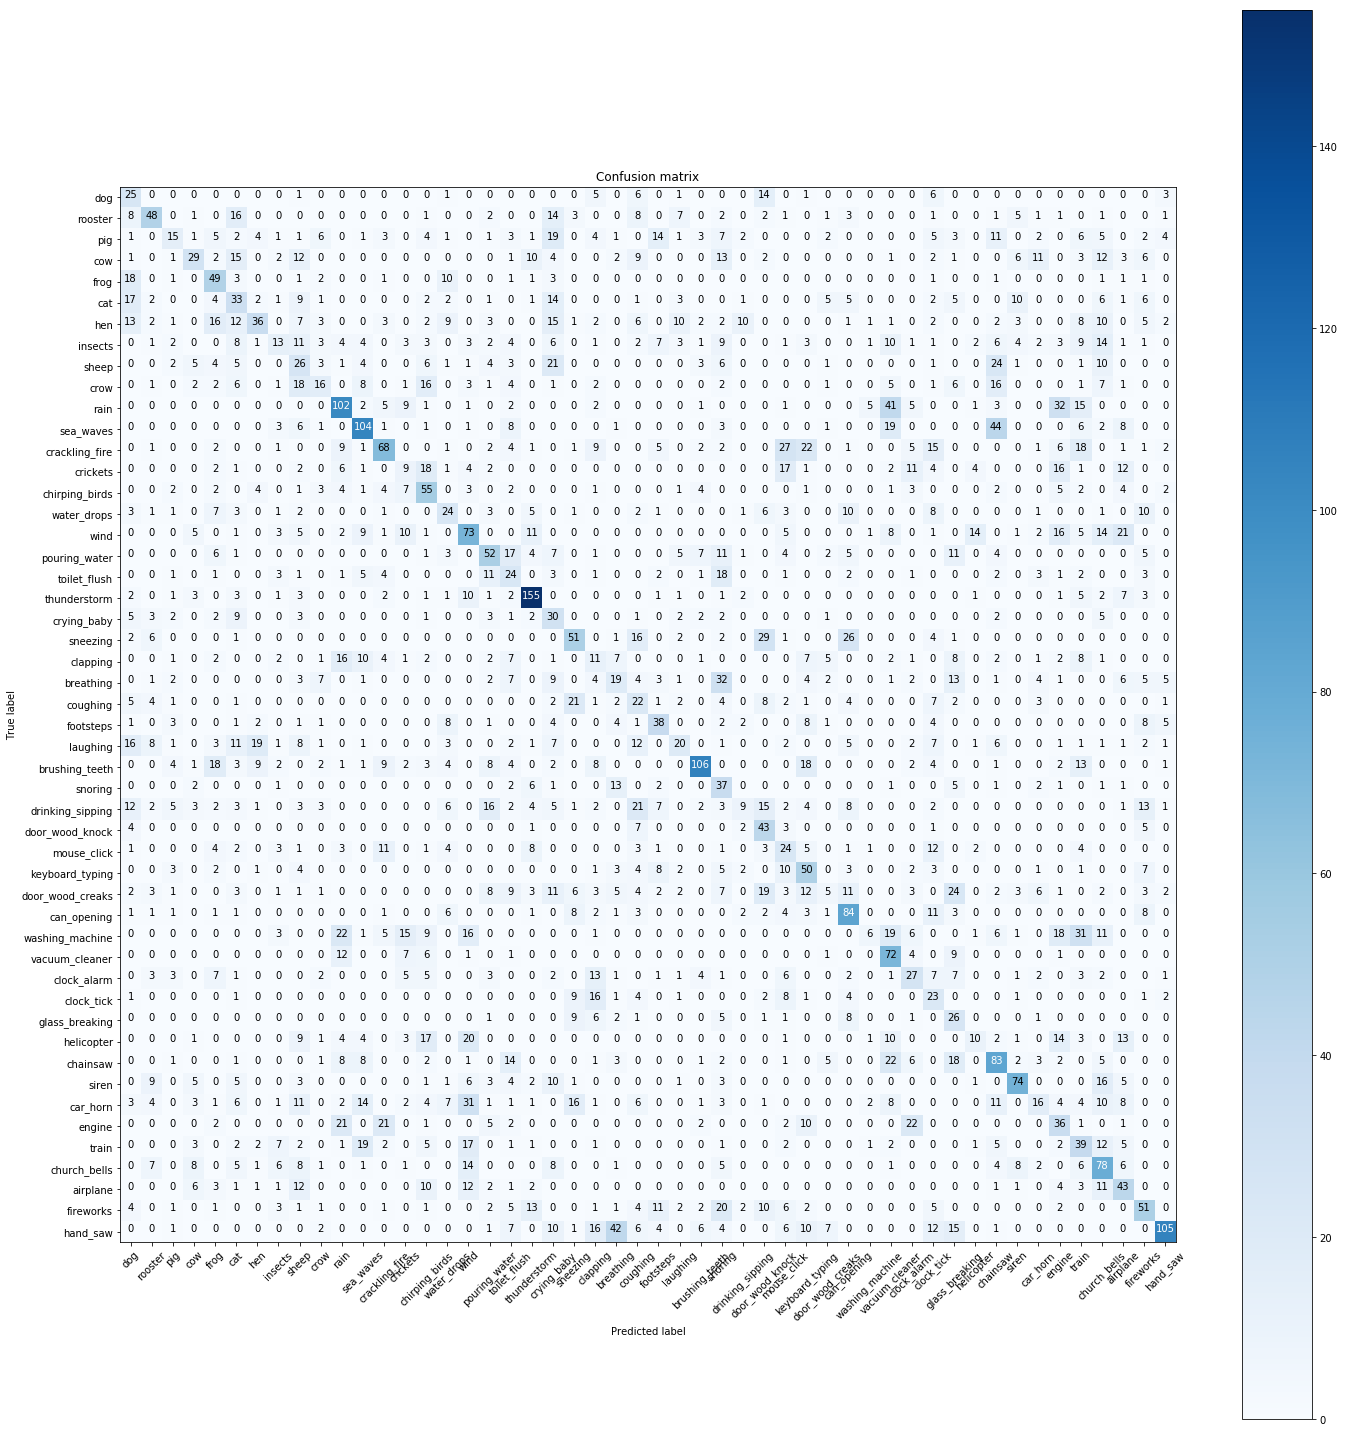

In [17]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_yy, pred))
cm = metrics.confusion_matrix(test_yy, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [18]:
predictions = []
full_targets = []
start_time = time.time()
pred_probs = []

for data_iloc in range(0,2000):
    s_time = time.time()
    x_file = ps.preprocess_file(dataset.iloc[data_iloc].filename,
                                                 blocksize=blocksize,
                                                 overlap=overlap)
    y_file = dataset.iloc[data_iloc].h_target
    yy_file = dataset.iloc[data_iloc].target
    
    pred = clf.predict(x_file, verbose=0)
    pred_probs.append(clf.predict_proba(x_file))
    b = Counter(pred)
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(yy_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))



Epoch 1/1
2/2 [==============================] - 0s 47ms/step - loss: 1.3344
	File Time: 0.8310408592224121
	File Time: 0.5905587673187256
	File Time: 0.4454939365386963
	File Time: 0.4370913505554199
	File Time: 0.4353506565093994
	File Time: 0.5132334232330322
	File Time: 0.29038214683532715
	File Time: 0.39609217643737793
	File Time: 0.6997165679931641
	File Time: 0.17479562759399414
	File Time: 0.15631747245788574
	File Time: 0.5935266017913818
	File Time: 0.4178645610809326
	File Time: 0.4342961311340332
	File Time: 0.11043977737426758
	File Time: 0.5119833946228027
	File Time: 0.5713374614715576
	File Time: 0.4648871421813965
	File Time: 0.43506526947021484
	File Time: 0.5720205307006836
	File Time: 0.48999929428100586
	File Time: 0.5823523998260498
	File Time: 0.5418479442596436
	File Time: 0.5751028060913086
	File Time: 0.5498032569885254
	File Time: 0.5540657043457031
	File Time: 0.5590465068817139
	File Time: 0.3940999507904053
	File Time: 0.43291354179382324
	File Time: 0.51

	File Time: 0.25984883308410645
	File Time: 0.4265921115875244
	File Time: 0.44582080841064453
	File Time: 0.5398197174072266
	File Time: 0.43183350563049316
	File Time: 0.4140927791595459
	File Time: 0.6024341583251953
	File Time: 0.3953390121459961
	File Time: 0.45145297050476074
	File Time: 0.5268495082855225
	File Time: 0.4009273052215576
	File Time: 0.4916861057281494
	File Time: 0.571610689163208
	File Time: 0.5067222118377686
	File Time: 0.42305707931518555
	File Time: 0.4000060558319092
	File Time: 0.39327454566955566
	File Time: 0.3163318634033203
	File Time: 0.39557838439941406
	File Time: 0.2540597915649414
	File Time: 0.41900014877319336
	File Time: 0.5233867168426514
	File Time: 0.30198121070861816
	File Time: 0.4114537239074707
	File Time: 0.4514281749725342
	File Time: 0.5580203533172607
	File Time: 0.5060820579528809
	File Time: 0.6075408458709717
	File Time: 0.3903803825378418
	File Time: 0.4589841365814209
	File Time: 0.49982261657714844
	File Time: 0.5649993419647217

	File Time: 0.633660078048706
	File Time: 0.5825560092926025
	File Time: 0.5542068481445312
	File Time: 0.45757341384887695
	File Time: 0.40604400634765625
	File Time: 0.5573084354400635
	File Time: 0.6337482929229736
	File Time: 0.43645143508911133
	File Time: 0.46042704582214355
	File Time: 0.4082329273223877
	File Time: 0.5676734447479248
	File Time: 0.5524711608886719
	File Time: 0.670163631439209
	File Time: 0.3105900287628174
	File Time: 0.4430811405181885
	File Time: 0.4636249542236328
	File Time: 0.5365684032440186
	File Time: 0.5585353374481201
	File Time: 0.23055171966552734
	File Time: 0.5132570266723633
	File Time: 0.31093335151672363
	File Time: 0.49351954460144043
	File Time: 0.5878446102142334
	File Time: 0.565540075302124
	File Time: 0.5450267791748047
	File Time: 0.44445013999938965
	File Time: 0.19026732444763184
	File Time: 0.2879669666290283
	File Time: 0.5019230842590332
	File Time: 0.2884552478790283
	File Time: 0.5078854560852051
	File Time: 0.4815089702606201
	F

	File Time: 0.41080188751220703
	File Time: 0.4942502975463867
	File Time: 0.26083922386169434
	File Time: 0.5357499122619629
	File Time: 0.5255720615386963
	File Time: 0.3688795566558838
	File Time: 0.2106947898864746
	File Time: 0.5072135925292969
	File Time: 0.4351646900177002
	File Time: 0.5874905586242676
	File Time: 0.42011332511901855
	File Time: 0.4409637451171875
	File Time: 0.4968295097351074
	File Time: 0.4853324890136719
	File Time: 0.4411344528198242
	File Time: 0.5689318180084229
	File Time: 0.6467001438140869
	File Time: 0.5047564506530762
	File Time: 0.4582545757293701
	File Time: 0.5213737487792969
	File Time: 0.5318021774291992
	File Time: 0.5112199783325195
	File Time: 0.5486884117126465
	File Time: 0.556239128112793
	File Time: 0.49331068992614746
	File Time: 0.4914126396179199
	File Time: 0.4906134605407715
	File Time: 0.5194482803344727
	File Time: 0.4602177143096924
	File Time: 0.41295695304870605
	File Time: 0.39516401290893555
	File Time: 0.44097018241882324
	F

	File Time: 0.2513387203216553
	File Time: 0.5199613571166992
	File Time: 0.48975443840026855
	File Time: 0.5194625854492188
	File Time: 0.4767148494720459
	File Time: 0.5907607078552246
	File Time: 0.42673492431640625
	File Time: 0.5594668388366699
	File Time: 0.5289387702941895
	File Time: 0.5839698314666748
	File Time: 0.5266883373260498
	File Time: 0.6610560417175293
	File Time: 0.43895435333251953
	File Time: 0.39279890060424805
	File Time: 0.40882015228271484
	File Time: 0.1094980239868164
	File Time: 0.3890092372894287
	File Time: 0.3872945308685303
	File Time: 0.4265265464782715
	File Time: 0.6114287376403809
	File Time: 0.26024317741394043
	File Time: 0.17626094818115234
	File Time: 0.39202141761779785
	File Time: 0.39960432052612305
	File Time: 0.3964366912841797
	File Time: 0.39747118949890137
	File Time: 0.40267157554626465
	File Time: 0.511131763458252
	File Time: 0.42479872703552246
	File Time: 0.20673179626464844
	File Time: 0.22368073463439941
	File Time: 0.182086229324

	File Time: 0.47548842430114746
	File Time: 0.46102094650268555
	File Time: 0.4402127265930176
	File Time: 0.54642653465271
	File Time: 0.3575136661529541
	File Time: 0.311492919921875
	File Time: 0.41541314125061035
	File Time: 0.5785353183746338
	File Time: 0.6462373733520508
	File Time: 0.43387937545776367
	File Time: 0.31561946868896484
	File Time: 0.3890986442565918
	File Time: 0.5252928733825684
	File Time: 0.5556163787841797
	File Time: 0.5836150646209717
	File Time: 0.6374623775482178
	File Time: 0.5145268440246582
	File Time: 0.4972050189971924
	File Time: 0.4669780731201172
	File Time: 0.48087143898010254
	File Time: 0.5452187061309814
	File Time: 0.5661242008209229
	File Time: 0.4866294860839844
	File Time: 0.5529775619506836
	File Time: 0.5351197719573975
	File Time: 0.584216833114624
	File Time: 0.652824878692627
	File Time: 0.6403584480285645
	File Time: 0.4309530258178711
	File Time: 0.4597022533416748
	File Time: 0.24335575103759766
	File Time: 0.23083758354187012
	File

	File Time: 0.4977378845214844
	File Time: 0.48934102058410645
	File Time: 0.48902082443237305
	File Time: 0.44657278060913086
	File Time: 0.3988609313964844
	File Time: 0.39011573791503906
	File Time: 0.5156238079071045
	File Time: 0.4232604503631592
	File Time: 0.5516197681427002
	File Time: 0.51564621925354
	File Time: 0.4048621654510498
	File Time: 0.45206189155578613
	File Time: 0.28166675567626953
	File Time: 0.5912892818450928
	File Time: 0.7063746452331543
	File Time: 0.5783252716064453
	File Time: 0.5959570407867432
	File Time: 0.5202443599700928
	File Time: 0.5024549961090088
	File Time: 0.6471590995788574
	File Time: 0.45113325119018555
	File Time: 0.396791934967041
	File Time: 0.39405226707458496
	File Time: 0.5685110092163086
	File Time: 0.19154763221740723
	File Time: 0.2605438232421875
	File Time: 0.15190672874450684
	File Time: 0.5430703163146973
	File Time: 0.04883933067321777
	File Time: 0.4692416191101074
	File Time: 0.45886731147766113
	File Time: 0.4218382835388183

	File Time: 0.5325982570648193
	File Time: 0.5723812580108643
	File Time: 0.5003437995910645
	File Time: 0.5520975589752197
	File Time: 0.5692846775054932
	File Time: 0.5029101371765137
	File Time: 0.5988883972167969
	File Time: 0.6438913345336914
	File Time: 0.3056931495666504
	File Time: 0.21758222579956055
	File Time: 0.2537820339202881
	File Time: 0.5449042320251465
	File Time: 0.4742114543914795
	File Time: 0.2608809471130371
	File Time: 0.2596116065979004
	File Time: 0.6535494327545166
	File Time: 0.5276751518249512
	File Time: 0.12776875495910645
	File Time: 0.3650479316711426
	File Time: 0.4024028778076172
	File Time: 0.40807580947875977
	File Time: 0.4021949768066406
	File Time: 0.40085482597351074
	File Time: 0.502310037612915
	File Time: 0.6227924823760986
	File Time: 0.43462419509887695
	File Time: 0.4616966247558594
	File Time: 0.543466329574585
	File Time: 0.7058353424072266
	File Time: 0.6756844520568848
	File Time: 0.29775166511535645
	File Time: 0.7182133197784424
	Fil

In [19]:
targs = np.vstack(full_targets)

0.6165
Confusion matrix, without normalization
[[31  1  0 ...  0  0  0]
 [ 0 33  0 ...  0  0  0]
 [ 0  1 15 ...  0  0  0]
 ...
 [ 0  0  0 ... 23  0  0]
 [ 0  0  0 ...  0 29  0]
 [ 0  0  0 ...  0  0 28]]


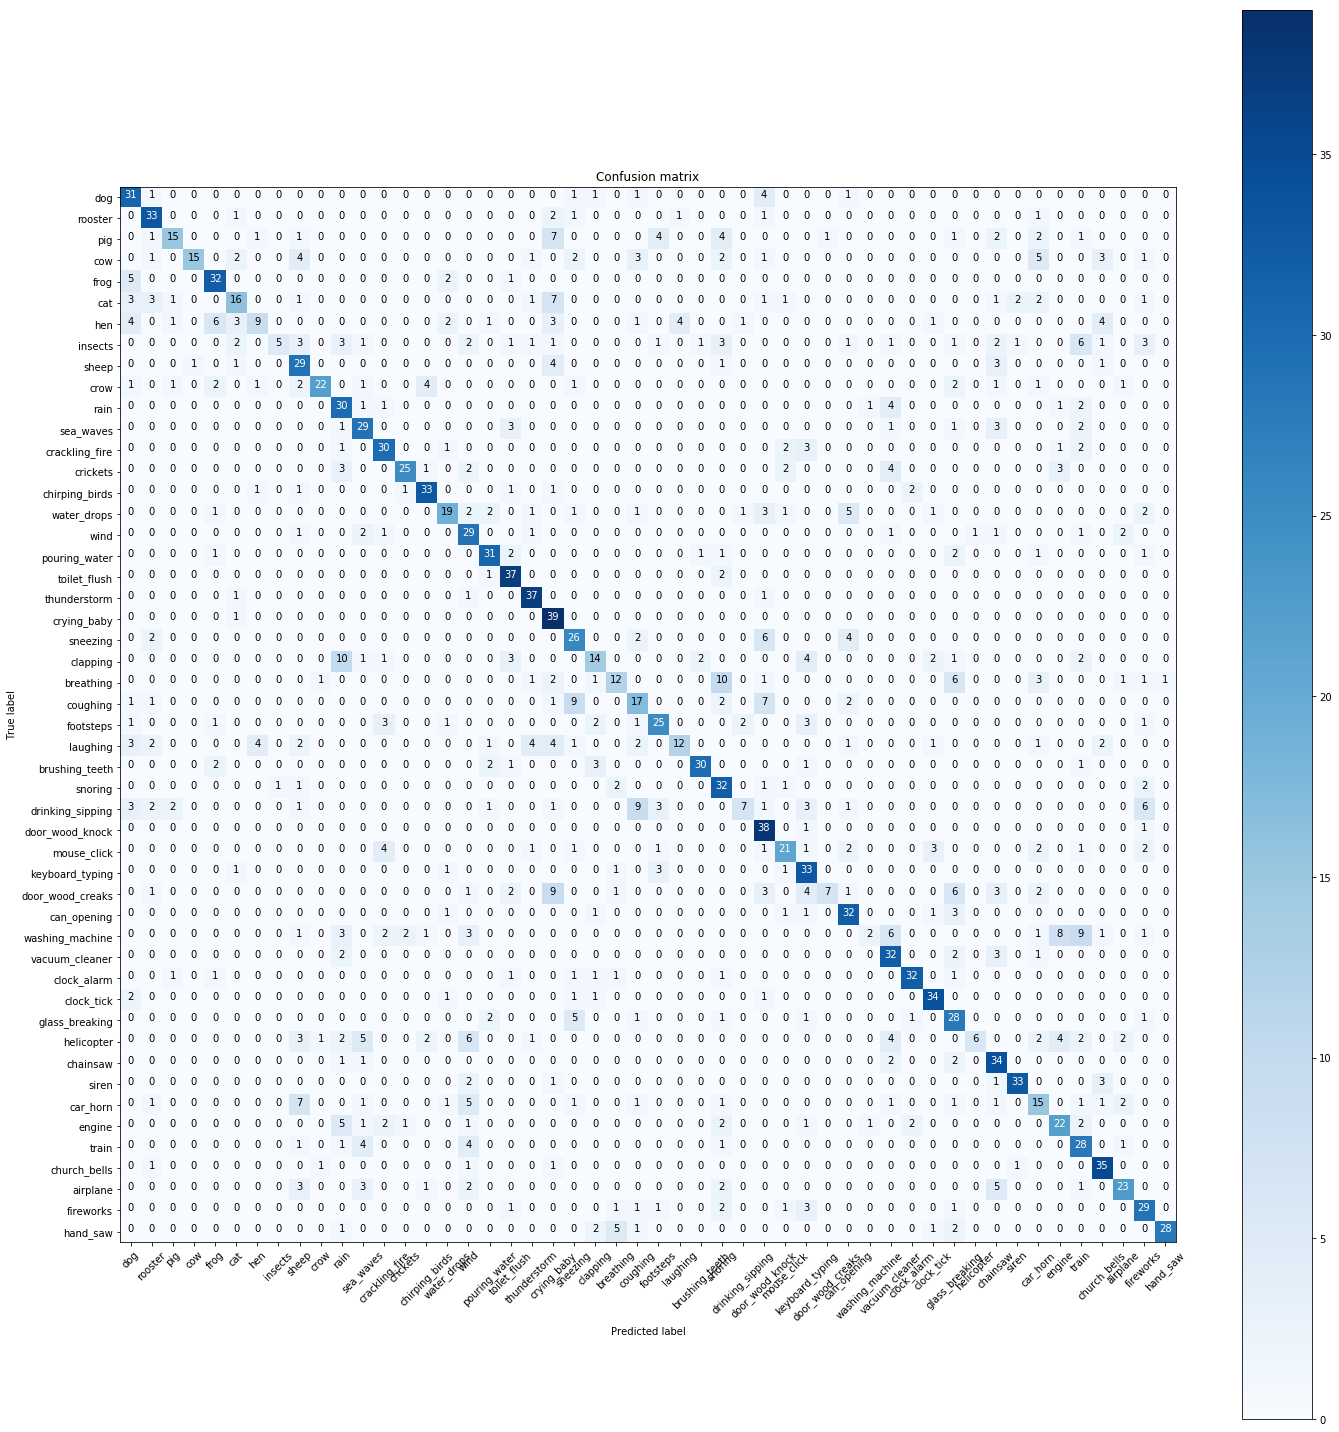

In [20]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [21]:
t_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False
                       )
t_df.head()

,target,h_target,metadata
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...


In [22]:
%%time

predictions = []
full_targets = []
start_time = time.time()
pred_probs = []
time_per_file = []

for data_iloc in range(0,2000):
    s_time = time.time()
    x_file = t_df.iloc[data_iloc].metadata

    y_file = dataset.iloc[data_iloc].h_target
    yy_file = dataset.iloc[data_iloc].target
    
    pred = clf.predict(x_file, verbose=0)
    b = Counter(pred)
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(yy_file)
    time_per_file.append(time.time() - s_time)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tAverage File Time: " + str(np.average(time_per_file)))
print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 0.0036144256591796875
	File Time: 0.003366708755493164
	File Time: 0.003306865692138672
	File Time: 0.004629373550415039
	File Time: 0.004955291748046875
	File Time: 0.0048754215240478516
	File Time: 0.0047070980072021484
	File Time: 0.0045206546783447266
	File Time: 0.0043065547943115234
	File Time: 0.004044532775878906
	File Time: 0.0040318965911865234
	File Time: 0.0028076171875
	File Time: 0.0026874542236328125
	File Time: 0.002610445022583008
	File Time: 0.0024843215942382812
	File Time: 0.002677440643310547
	File Time: 0.002653360366821289
	File Time: 0.002734661102294922
	File Time: 0.0025997161865234375
	File Time: 0.0026001930236816406
	File Time: 0.00269317626953125
	File Time: 0.0027914047241210938
	File Time: 0.002730846405029297
	File Time: 0.002750873565673828
	File Time: 0.002685070037841797
	File Time: 0.0026144981384277344
	File Time: 0.002710103988647461
	File Time: 0.002794981002807617
	File Time: 0.002736806869506836
	File Time: 0.0027742385864257812
	Fi

	File Time: 0.0029630661010742188
	File Time: 0.002753734588623047
	File Time: 0.002803802490234375
	File Time: 0.0028007030487060547
	File Time: 0.002750873565673828
	File Time: 0.0027892589569091797
	File Time: 0.0027556419372558594
	File Time: 0.0027494430541992188
	File Time: 0.0026895999908447266
	File Time: 0.002710103988647461
	File Time: 0.0027649402618408203
	File Time: 0.0027480125427246094
	File Time: 0.002804279327392578
	File Time: 0.0027549266815185547
	File Time: 0.0027513504028320312
	File Time: 0.0027451515197753906
	File Time: 0.0026922225952148438
	File Time: 0.002706289291381836
	File Time: 0.0027103424072265625
	File Time: 0.002729177474975586
	File Time: 0.0026578903198242188
	File Time: 0.0028753280639648438
	File Time: 0.002774477005004883
	File Time: 0.002750396728515625
	File Time: 0.002727031707763672
	File Time: 0.0027151107788085938
	File Time: 0.0026938915252685547
	File Time: 0.0027310848236083984
	File Time: 0.0027816295623779297
	File Time: 0.0027687549

	File Time: 0.002447366714477539
	File Time: 0.002449512481689453
	File Time: 0.0024476051330566406
	File Time: 0.002362966537475586
	File Time: 0.002529621124267578
	File Time: 0.002467632293701172
	File Time: 0.002435922622680664
	File Time: 0.0024619102478027344
	File Time: 0.002428770065307617
	File Time: 0.002458810806274414
	File Time: 0.00250244140625
	File Time: 0.004721641540527344
	File Time: 0.00455474853515625
	File Time: 0.0043561458587646484
	File Time: 0.004581451416015625
	File Time: 0.004397153854370117
	File Time: 0.004286527633666992
	File Time: 0.004273891448974609
	File Time: 0.004060506820678711
	File Time: 0.00484013557434082
	File Time: 0.004786252975463867
	File Time: 0.005032062530517578
	File Time: 0.004656314849853516
	File Time: 0.004549264907836914
	File Time: 0.004341840744018555
	File Time: 0.0041201114654541016
	File Time: 0.004267215728759766
	File Time: 0.004347324371337891
	File Time: 0.004564046859741211
	File Time: 0.005005359649658203
	File Time: 

	File Time: 0.005038261413574219
	File Time: 0.004401206970214844
	File Time: 0.0051784515380859375
	File Time: 0.004548788070678711
	File Time: 0.004355907440185547
	File Time: 0.004280567169189453
	File Time: 0.0043413639068603516
	File Time: 0.012883424758911133
	File Time: 0.008925914764404297
	File Time: 0.011569976806640625
	File Time: 0.004863262176513672
	File Time: 0.0024781227111816406
	File Time: 0.002725362777709961
	File Time: 0.0027141571044921875
	File Time: 0.00261688232421875
	File Time: 0.002583742141723633
	File Time: 0.0025827884674072266
	File Time: 0.0025496482849121094
	File Time: 0.002557992935180664
	File Time: 0.0024809837341308594
	File Time: 0.0025968551635742188
	File Time: 0.0026078224182128906
	File Time: 0.0033376216888427734
	File Time: 0.0031998157501220703
	File Time: 0.004725217819213867
	File Time: 0.0027725696563720703
	File Time: 0.0031397342681884766
	File Time: 0.0029783248901367188
	File Time: 0.004139423370361328
	File Time: 0.0048952102661132

	File Time: 0.003377676010131836
	File Time: 0.003175497055053711
	File Time: 0.0029745101928710938
	File Time: 0.002858400344848633
	File Time: 0.0028412342071533203
	File Time: 0.002886533737182617
	File Time: 0.002972126007080078
	File Time: 0.002913236618041992
	File Time: 0.002893209457397461
	File Time: 0.0028574466705322266
	File Time: 0.002881288528442383
	File Time: 0.0029158592224121094
	File Time: 0.0029518604278564453
	File Time: 0.0027463436126708984
	File Time: 0.002807140350341797
	File Time: 0.00293731689453125
	File Time: 0.0029146671295166016
	File Time: 0.0028884410858154297
	File Time: 0.0028815269470214844
	File Time: 0.0029494762420654297
	File Time: 0.0029065608978271484
	File Time: 0.0027418136596679688
	File Time: 0.002687692642211914
	File Time: 0.0027091503143310547
	File Time: 0.0029904842376708984
	File Time: 0.002740144729614258
	File Time: 0.0030601024627685547
	File Time: 0.0029449462890625
	File Time: 0.0026078224182128906
	File Time: 0.0029499530792236

	File Time: 0.002634286880493164
	File Time: 0.002386331558227539
	File Time: 0.002588987350463867
	File Time: 0.0025415420532226562
	File Time: 0.0024781227111816406
	File Time: 0.0025167465209960938
	File Time: 0.0025098323822021484
	File Time: 0.002477884292602539
	File Time: 0.0025484561920166016
	File Time: 0.0025360584259033203
	File Time: 0.0025038719177246094
	File Time: 0.0025675296783447266
	File Time: 0.002465486526489258
	File Time: 0.002429485321044922
	File Time: 0.0023262500762939453
	File Time: 0.0023894309997558594
	File Time: 0.0025720596313476562
	File Time: 0.0024404525756835938
	File Time: 0.0024101734161376953
	File Time: 0.0024573802947998047
	File Time: 0.002551555633544922
	File Time: 0.0024657249450683594
	File Time: 0.0025484561920166016
	File Time: 0.002355337142944336
	File Time: 0.0025866031646728516
	File Time: 0.002680540084838867
	File Time: 0.0046575069427490234
	File Time: 0.004996776580810547
	File Time: 0.004685163497924805
	File Time: 0.00541949272

	File Time: 0.004007816314697266
	File Time: 0.004122734069824219
	File Time: 0.004082202911376953
	File Time: 0.003483295440673828
	File Time: 0.0027620792388916016
	File Time: 0.0024983882904052734
	File Time: 0.002501249313354492
	File Time: 0.00250244140625
	File Time: 0.0024597644805908203
	File Time: 0.0024018287658691406
	File Time: 0.0024950504302978516
	File Time: 0.002500295639038086
	File Time: 0.0024709701538085938
	File Time: 0.0024657249450683594
	File Time: 0.002480030059814453
	File Time: 0.002473592758178711
	File Time: 0.002531766891479492
	File Time: 0.002507448196411133
	File Time: 0.0025069713592529297
	File Time: 0.0024471282958984375
	File Time: 0.0026102066040039062
	File Time: 0.0025577545166015625
	File Time: 0.0026412010192871094
	File Time: 0.0025310516357421875
	File Time: 0.002535104751586914
	File Time: 0.0025298595428466797
	File Time: 0.0025212764739990234
	File Time: 0.0025658607482910156
	File Time: 0.0025446414947509766
	File Time: 0.0025494098663330

	File Time: 0.005290985107421875
	File Time: 0.0035610198974609375
	File Time: 0.0041806697845458984
	File Time: 0.01089620590209961
	File Time: 0.0057981014251708984
	File Time: 0.009735107421875
	File Time: 0.007803678512573242
	File Time: 0.005609989166259766
	File Time: 0.003545999526977539
	File Time: 0.004158496856689453
	File Time: 0.0202481746673584
	File Time: 0.0065920352935791016
	File Time: 0.0057713985443115234
	File Time: 0.019254446029663086
	File Time: 0.0048828125
	File Time: 0.006171226501464844
	File Time: 0.007638692855834961
	File Time: 0.0066602230072021484
	File Time: 0.0036468505859375
	File Time: 0.002952098846435547
	File Time: 0.0023179054260253906
	File Time: 0.002172708511352539
	File Time: 0.002318143844604492
	File Time: 0.0022013187408447266
	File Time: 0.002229452133178711
	File Time: 0.002227306365966797
	File Time: 0.0022275447845458984
	File Time: 0.0022161006927490234
	File Time: 0.002923727035522461
	File Time: 0.003921031951904297
	File Time: 0.00

0.6165
Confusion matrix, without normalization
[[31  1  0 ...  0  0  0]
 [ 0 33  0 ...  0  0  0]
 [ 0  1 15 ...  0  0  0]
 ...
 [ 0  0  0 ... 23  0  0]
 [ 0  0  0 ...  0 29  0]
 [ 0  0  0 ...  0  0 28]]


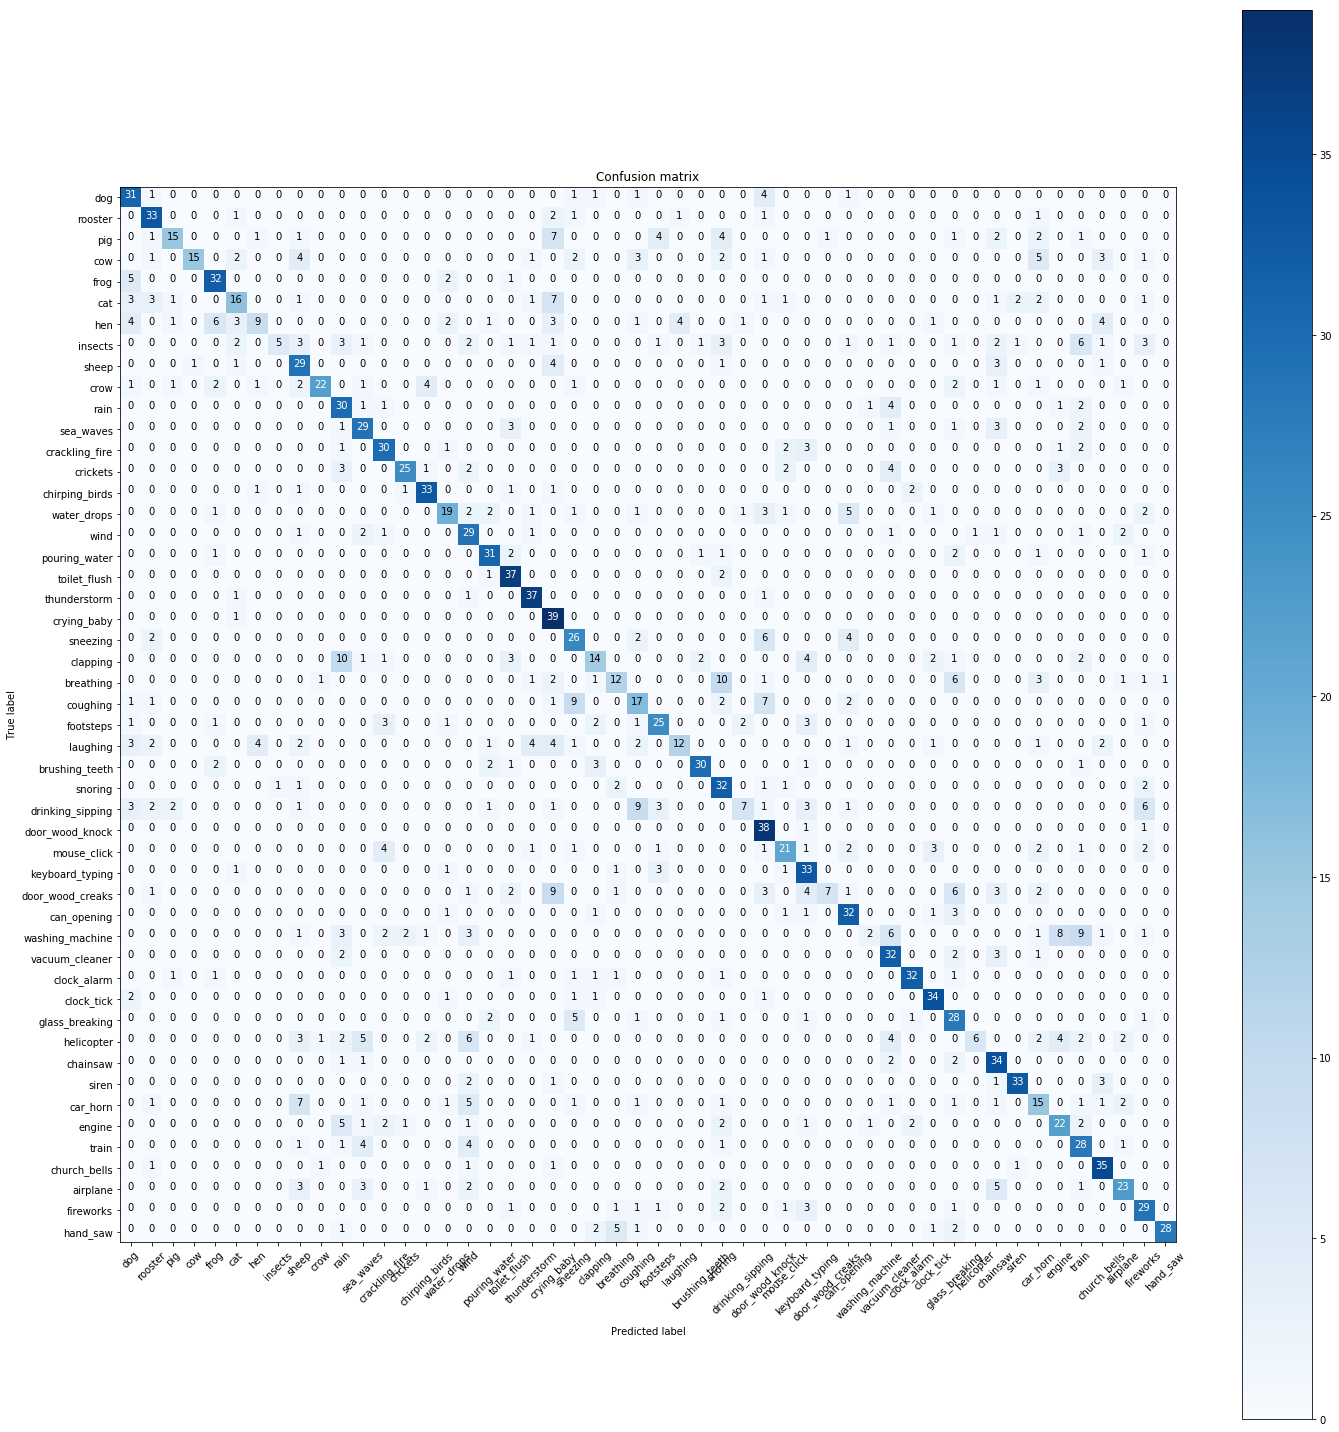

In [23]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [24]:
%%time
from sklearn.model_selection import cross_validate

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=80, score_func=chi2)),
    ('feat_red', PCA(n_components=50)),
    ('classify', KerasClassifier(build_fn=deep_net, 
                       epochs=50, 
                       batch_size=35, 
                       verbose=0)
    )
])

scores = cross_validate(clf, train_X, train_yy, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               6528      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
__________

CPU times: user 20min 28s, sys: 9min 45s, total: 30min 13s
Wall time: 8min 52s


In [25]:
clf.fit(train_X, train_yy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               6528      
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
__________

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=80, score_func=<function chi2 at 0x7fa735232378>)), ('feat_red', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa7a9b95cc0>)])

In [26]:
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,train_accuracy,train_precision_macro,train_recall_macro
0,100.408170,0.651984,0.277937,0.277001,0.280842,0.535442,0.543739,0.527946
1,101.193880,0.678387,0.290693,0.274635,0.291516,0.543842,0.548022,0.539723
2,103.726464,0.817640,0.273805,0.265066,0.281651,0.534858,0.542588,0.528133
3,105.229717,0.852281,0.286792,0.273728,0.284379,0.523649,0.527972,0.518941
4,108.298968,0.890342,0.266846,0.256849,0.275396,0.531914,0.547023,0.529282


In [27]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []

    for data_iloc in range(0,len(t_df)):
        x_file = t_df.iloc[data_iloc].metadata

        y_file = dataset.iloc[data_iloc].h_target
        yy_file = dataset.iloc[data_iloc].target

        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file)
        })
        
    return predictions

In [28]:
%%time
preds = query_dataset('dog')

CPU times: user 16.2 s, sys: 1.43 s, total: 17.6 s
Wall time: 13.4 s


In [29]:
sorted_result = pd.DataFrame(preds).sort_values(by=['prob'], ascending=False).reset_index(drop=True)

In [30]:
sorted_result.head()

,ds_id,file,prediction,prob
0,522,2-122104-B-0.wav,"[0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.643035
1,1761,5-203128-B-0.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.618154
2,521,2-122104-A-0.wav,"[0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 0, 0, 0,...",0.584376
3,1460,4-188287-A-9.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19]",0.573872
4,1832,5-217158-A-0.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 15, 0,...",0.564759


In [31]:
# Checking index
misclass = []
for data_iloc in range(0, 20):
    row = sorted_result.iloc[data_iloc]
    if dataset.iloc[row.ds_id].target != classes.index('dog'):
        misclass.append(classes[dataset.iloc[row.ds_id].target])
        
print(misclass)

['crow', 'frog', 'frog']


In [32]:
# Checking index
misclass = []
for data_iloc in range(0, 10):
    row = sorted_result.iloc[data_iloc]
    if dataset.iloc[row.ds_id].target != classes.index('dog'):
        misclass.append(classes[dataset.iloc[row.ds_id].target])
        
print(misclass)

['crow']
